# Задание 1


### Целью этого задания является знакомство со стандартными контейнерами и некторыми функциями из стандартных библиотек для машинного обучения.

Напишите наивный байесовский классификатор и сравните его с реализацией NaiveBayesClassifier из библиотеки nltk.

Написанный вами классификатор должен обладать следующими свойствами:
<ul>
<li>В предложенном интерфейсе класса должны быть реализованы все методы и все поля. Для их хранения предподсчитанных данных рекомендуется использовать контейнеры Counter или defaultdict из библиотеки collections. Для предсказания категории рекомендуется использовать numpy.</li>
<li>Должна использоваться модель, предложенная в теории.</li>
<li>Точность предсказаний не менее <b>0.9</b>!</li>
<li>После реализации класса протестируйте его с помощью кроссвалидации с k=10. Рекомендуется использовать класс KFold из библиотеки sklearn.</li>
<li>Постройте диаграмму размаха для классификаторов (своего и из библиотеки).</li>
</ul>

### Теория

Теория находится в файле problems1-theory.pdf

# Решение

In [1]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import nltk
from nltk import NaiveBayesClassifier
from matplotlib import pyplot as plt

%matplotlib inline

### Прочитайте данные из файла

In [2]:
data_path = "ham-spam.csv"

df = pd.read_csv(data_path)
df.head()

,target,msg
0,ham,Subject : re : 2 . 882 s - > np np > date : su...
1,ham,Subject : s - > np + np the discussion of s - ...
2,ham,Subject : 2 . 882 s - > np np . . . for me it ...
3,ham,"Subject : gent conference "" for the listserv ""..."
4,ham,Subject : query : causatives in korean could a...


In [3]:
df.groupby("target").count()

,msg
target,
ham,2412
spam,481


### Реализуйте все методы в классе NaiveBayes

In [4]:
class NaiveBayes(object):
    """
    Наивный байесовский классификатор.
    Для каждого входного сообщения слово учитывается один раз при расчете итоговой вероятности.

    Parameters
    ----------
    category_priors : default | None, optional, default None
        Априорные вероятности категорий.
        Если None, то классификатор должен сам их вычислить.

    weight : float, optional, default 1
        Вес одного слова в формуле взвешенной вероятности

    supposed_prob : float, optional, default 0.5
        Предполагаемая вероятность слова в категории
    """

    def __init__(self, category_priors=None, weight=1, supposed_prob=0.5):
        self.category_priors = category_priors
        self.weight = weight
        self.supposed_prob = supposed_prob

        # Количество отдельных слов в заданной категории
        # feature_category_counts[cat][word] - число слов word в категории cat
        self.feature_category_counts = defaultdict(lambda: defaultdict(int))
        
        # Суммарное количество слов в данной категории
        self.category_feature_counts = defaultdict(int)
        
        # Количество всех документов в данной категории
        self.category_doc_counts = defaultdict(int)

        # Количество встреч слова во всех сообщениях
        self.feature_counts = defaultdict(int)

    def fit(self, x_train, y_train):
        """
        Производит обучение наивного байесовского классификатора.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        y_train : list of str
            содержит список меток (названий категорий) для сообщений из x_train

        Returns
        -------
        self : object
            Returns self
        """
        # Подсчитываем количество категорий, документов и слов в каждой категории
        # и количество встреч слова во всех сообщениях
        self.word_count = 0 # общее число слов
        for document, category in zip(x_train, y_train):
            self.category_doc_counts[category] += 1
            document = document.split() if type(document) != list else document
            for word in set(document):
                self.feature_category_counts[category][word] += 1
                self.category_feature_counts[category] += 1
                self.feature_counts[word] += 1
                self.word_count += 1
        
        # Если априорные вероятности категорий не заданы, то надо аппроксимировать их
        count_documents = len(y_train) # общее число документов
        if self.category_priors is None:
            self.category_priors = defaultdict(float)
            for category, quantity in self.category_doc_counts.items():
                self.category_priors[category] = quantity / count_documents
            
        return self

    def predict(self, text):
        """
        Предсказывает метки категорий для text.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        Returns
        -------
        categories : list of str
            Возвращает названия категорий для text.
        """
        count_documents = 0
        lst = []
        if type(text) == str:
            lst = text.split()
            count_documents = 1
        elif " " in text[0]:
            for document in text:
                lst.append(document.split())
                count_documents += 1
        else:
            count_documents = 1
            lst = text

        categories = []
        cat_list = self.get_categories()
        for i in range(count_documents):
            document = lst[i]
            cat_idx = np.argmax(self.get_probs(document))
            cat = cat_list[cat_idx]
            categories.append(cat)
        
        return categories

    def score(self, text, labels):
        """
        Возвращает точность предсказаний на text для правильных категорий labels.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.
        labels : list of str
            Список категорий для каждого токена из text.

        Returns
        -------
        acc : float
            Точность предсказания.
        """
        pred = self.predict(text)
        guessed = np.sum(np.array(pred) == np.array(labels))
        acc = guessed / len(pred)
        return acc

    def get_probs(self, text):
        """
        Считает вероятности принадлежности текста (text) к каждой из категорий

        Parameters
        ----------
        text : list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.

        Returns
        -------
        probs : list of float
            Возвращает вероятности probs всех категорий для текста text
            в порядке их следования в self.category_doc_counts.
        """
        # Токенизируем текст, если это необходимо
        words = text if type(text) == list else text.split()
        probs = [self.get_category_prob(cat, words) for cat in self.get_categories()]
        return probs

    def get_category_prob(self, cat, text):
        """
        Считает логарифм вероятности принадлежности сообщения text к категории cat.

        Parameters
        ----------
        cat : str
            Название категории.

        text : list of str
            Список из слов.

        Returns
        -------
        log_prob : float
            Возвращает логарифм вероятности категории cat для текста text.
        """
        log_prob = np.log(self.category_priors[cat])
        for word in set(text):
            word_prob = self.get_weighted_feature_prob(cat, word)
            log_prob += np.log(word_prob)
        return log_prob

    def get_weighted_feature_prob(self, cat, feature):
        """
        Вычисляет взвешенную вероятность P(Слово|Категория).

        Parameters
        ----------
        cat : str
            Название категории.

        feature : str
            Слово из текста.

        Returns
        -------
        prob : float
            Возвращает взвешенную вероятность слова feature при условии категории cat.
        """
        total = self.feature_counts[feature]
        # Если мы всретили новое слово, то воспользуеся suppoused_prob
        if total == 0:
            return self.supposed_prob
        # Вычисляем условную вероятность данного слова при данной категории
        prob_cond = self.feature_category_counts[cat][feature] / self.category_feature_counts[cat]
        # Вычисляем априорную вероятность слова
        # То есть число встреч данного слова / общее число слов
        prob_priory = self.feature_counts[feature] / self.word_count
        # Вычисляем средневзвешенную вероятность
        prob = (self.weight * prob_priory + total * prob_cond) / (self.weight + total)
        return prob

    def get_categories(self):
        """
        Возвращает список названий всех категорий.
        Returns
        -------
        cat_list : list of str
        """
        cat_list = list(self.category_doc_counts.keys())
        return cat_list

### Сравните вашу реализацию и реализацию из библиотеки nltk

Для использования классификатора из библиотеки не забудьте предподготовить данные. Для подсчета точности этого классификатора можете использовать accuracy_score из метрик sklearn. Для подсчета точности предсказаний вашего классификатора используйте функцию score, которую вы опишете.

#### Протестируем наш классификатор

In [5]:
X = df[["msg"]].values.flatten()
y = df[["target"]].values.flatten()

In [6]:
accuracy = []
kf = KFold(n_splits=10, random_state=1, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    clf = NaiveBayes(weight=1)
    clf.fit(X_train.tolist(), y_train.tolist())
    accuracy.append(clf.score(X_test.tolist(), y_test.tolist()))
np.mean(accuracy)

0.9923970886529053

#### Протестируем реализацию из nltk

In [7]:
X = df[["msg"]].values.flatten()
y = df[["target"]].values.flatten()

In [8]:
# Предобработка данных для классификатора nltk, если требуется
def create_word_features(message):
    dct = {word: True for word in set(message)}
    return dct

X = np.array([create_word_features(message) for message in X])

In [9]:
# Используйте процедуру KFold для проверки качества классификаторов
accuracy_nltk = []
kf = KFold(n_splits=10, random_state=1, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    train_set = [(x, y) for x, y in zip(X_train.tolist(), y_train.tolist())]
#     print(train_set)
    test_set = [(x, y) for x, y in zip(X_test.tolist(), y_test.tolist())]
    clf = NaiveBayesClassifier.train(train_set)
    accuracy_nltk.append(nltk.classify.util.accuracy(clf, test_set))
np.mean(accuracy_nltk)

0.9083999522729986

### Постройте графики размаха для двух классификаторов на одной фигуре.

Рекомендуется использовать встроенные функции построения графиков в pandas.

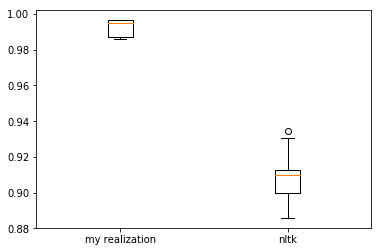

In [10]:
plt.boxplot([accuracy, accuracy_nltk], labels=["my realization", "nltk"])
plt.show()

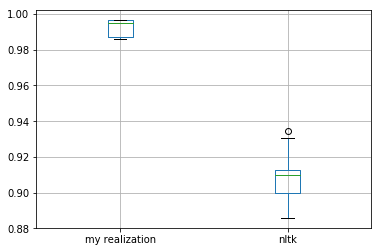

In [11]:
data = pd.DataFrame({"my realization": accuracy, "nltk": accuracy_nltk})
data.boxplot()
plt.show()